In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch, torchvision
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
import torch.nn.functional as F

import gc
import PIL
from time import time

from sklearn.model_selection import train_test_split

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

seed = 42

In [2]:
def breaker():
    print("\n" + 50*"-" + "\n")

def head(x, no_of_ele=5):
    print(x[:no_of_ele])

In [3]:
images = np.load("../input/rccl-ds-384/images_1x384x384.npy")
labels = np.load("../input/rccl-ds-384/labels.npy")

start_time = time()
tr_images, va_images, tr_labels, va_labels = train_test_split(images, labels, test_size=0.2,
                                                              shuffle=True, random_state=seed)

breaker()
print("Time Taken to Load Data : {:.2f} seconds".format(time() - start_time))

del images, labels, start_time

breaker()
print("Garbage Collected : {}".format(gc.collect()))
breaker()


--------------------------------------------------

Time Taken to Load Data : 3.16 seconds

--------------------------------------------------

Garbage Collected : 56

--------------------------------------------------



In [4]:
class DS(Dataset):
    def __init__(this, X=None, y=None, transform=None, mode="train"):
        this.mode = mode
        this.transform = transform
        this.X = X
        if mode == "train":
            this.y = y
                 
    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        img = this.transform(this.X[idx])
        if this.mode == "train":
            return img, torch.FloatTensor(this.y[idx])
        else:
            return img

In [5]:
class CFG():
    tr_batch_size = 64
    # va_batch_size = 128
    ts_batch_size = 64
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    in_channels = 1
    OL = 11
    
    def __init__(this, epochs=50, n_folds=5):
        this.epochs = epochs
        this.n_folds = n_folds

In [6]:
class Model(nn.Module):
    def __init__(this, name=None, pretrained=True, in_channels=None, OL=None):

        super(Model, this).__init__()
        
        if name == "alexnet":
            this.model = models.alexnet(pretrained=pretrained, progress=True)
        elif name == "vgg11":
            this.model = models.vgg11(pretrained=pretrained, progress=True)
        elif name == "vgg11_bn":
            this.model = models.vgg11_bn(pretrained=pretrained, progress=True)
        elif name == "vgg13":
            this.model = models.vgg13(pretrained=pretrained, progress=True)
        elif name == "vgg13_bn":
            this.model = models.vgg13_bn(pretrained=pretrained, progress=True)
        elif name == "vgg16":
            this.model = models.vgg16(pretrained=pretrained, progress=True)
        elif name == "vgg16_bn":
            this.model = models.vgg16_bn(pretrained=pretrained, progress=True)
        elif name == "vgg19":
            this.model = models.vgg19(pretrained=pretrained, progress=True)
        elif name == "vgg19_bn":
            this.model = models.vgg19_bn(pretrained=pretrained, progress=True)
        
        for params in this.model.parameters():
            params.requires_grad = False
        
        this.model.features[0] = nn.Conv2d(in_channels=in_channels, 
                                           out_channels=this.model.features[0].out_channels, 
                                           kernel_size=this.model.features[0].kernel_size, 
                                           stride=this.model.features[0].stride,
                                           padding=this.model.features[0].padding)
        
        this.model.classifier[-1] = nn.Linear(in_features=this.model.classifier[-1].in_features, 
                                              out_features=OL)
        
        
    def getOptimizer(this, lr=1e-3, wd=0):
        return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)
    
    def getMultiStepLR(this, optimizer=None, milestones=None, gamma=0.1):
        return optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=milestones, gamma=gamma)

    def getPlateauLR(this, optimizer=None, patience=5, eps=1e-8):
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps, verbose=True)

    def forward(this, x):
        x = this.model(x)
        return x

In [7]:
def fit_(model=None, optimizer=None, scheduler=None, epochs=None, early_stopping_patience=5,
         trainloader=None, validloader=None, criterion=None, device=None, verbose=False, path=None):
    
    breaker()
    print("Training ...")
    breaker()

    # model.to(device)

    Losses = []

    bestLoss = {"train" : np.inf, "valid" : np.inf}
    DLS = {"train" : trainloader, "valid" : validloader}
    
    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss = {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            lossPerPass = []

            for X, y in DLS[phase]:
                X, y = X.to(device), y.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = criterion(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass.append(loss.item())
            epochLoss[phase] = np.mean(np.array(lossPerPass))
        Losses.append(epochLoss)

        """if epochLoss["valid"] < bestLoss["valid"]: # or epochAccs["valid"] > bestAccs["valid"]:
            bestLoss = epochLoss
            torch.save(model.state_dict(), "./Epoch_{}.pt".format(e+1))
            early_stopping_step = 0
        else:
            early_stopping_step += 1
            if early_stopping_step > early_stopping_patience:
                print("Early Stopping at Epoch {}".format(e+1))
                break"""

        torch.save(model.state_dict(), "./Epoch_{}.pt".format(e+1))

        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            bestLossEpoch = e+1

        if scheduler:
            # scheduler.step()
            scheduler.step(epochLoss["valid"])

        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], time()-e_st))
            

    breaker()
    print("-----> Best Validation Loss at Epoch {}".format(bestLossEpoch))
    breaker()
    print("Time Taken [{} Epochs] : {:.2f} minutes".format(epochs, (time()-start_time)/60))
    breaker()
    print("Training Complete")
    breaker()

    return Losses, bestLossEpoch

def predict_(model=None, dataloader=None, device=None, path=None):
    if path:
        model.load_state_dict(torch.load(path))
    
    model.to(device)
    model.eval()

    y_pred = torch.zeros(1, 11).tp(device)

    for X, y in dataloader:
        X = X.to(device)
        with torch.no_grad():
            output = torch.sigmoid(model(X))
        y_pred = torch.cat((y_pred, output), dim=0)
    
    return y_pred.detach().cpu().numpy()

In [8]:
cfg = CFG(epochs=30, n_folds=None)

tr_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.RandomRotation(degrees=45, resample=PIL.Image.BILINEAR, fill=None)])
va_transform = transforms.Compose([transforms.ToTensor(), ])

tr_data_setup = DS(X=tr_images, y=tr_labels, transform=tr_transform, mode="train")
va_data_setup = DS(X=va_images, y=va_labels, transform=va_transform, mode="train")

tr_data = DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(seed))
va_data = DL(va_data_setup, batch_size=cfg.tr_batch_size, shuffle=False)

del tr_data_setup, va_data_setup

model = Model(name="vgg11_bn", pretrained=True, in_channels=cfg.in_channels, OL=cfg.OL).to(cfg.device)
optimizer = model.getOptimizer(lr=1e-3, wd=1e-5)
scheduler = model.getPlateauLR(optimizer=optimizer, patience=4, eps=1e-8)

Losses, bestLossEpoch = fit_(model=model, optimizer=optimizer, scheduler=scheduler, epochs=cfg.epochs,
                             trainloader=tr_data, validloader=va_data,
                             criterion=nn.BCEWithLogitsLoss(), device=cfg.device,
                             verbose=True)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth




--------------------------------------------------

Training ...

--------------------------------------------------

Epoch: 1 | Train Loss: 0.28731 | Valid Loss: 0.28120 | Time: 528.24 seconds
Epoch: 2 | Train Loss: 0.27911 | Valid Loss: 0.29532 | Time: 522.27 seconds
Epoch: 3 | Train Loss: 0.27917 | Valid Loss: 0.27796 | Time: 521.88 seconds
Epoch: 4 | Train Loss: 0.27841 | Valid Loss: 0.27573 | Time: 521.92 seconds
Epoch: 5 | Train Loss: 0.27885 | Valid Loss: 0.27507 | Time: 523.26 seconds
Epoch: 6 | Train Loss: 0.27738 | Valid Loss: 0.28273 | Time: 523.58 seconds
Epoch: 7 | Train Loss: 0.27784 | Valid Loss: 0.27811 | Time: 522.89 seconds
Epoch: 8 | Train Loss: 0.27668 | Valid Loss: 0.27497 | Time: 524.93 seconds
Epoch: 9 | Train Loss: 0.27684 | Valid Loss: 0.27315 | Time: 524.96 seconds
Epoch: 10 | Train Loss: 0.27701 | Valid Loss: 0.26837 | Time: 525.39 seconds
Epoch: 11 | Train Loss: 0.27593 | Valid Loss: 0.26756 | Time: 531.23 seconds
Epoch: 12 | Train Loss: 0.27694 | Valid Lo

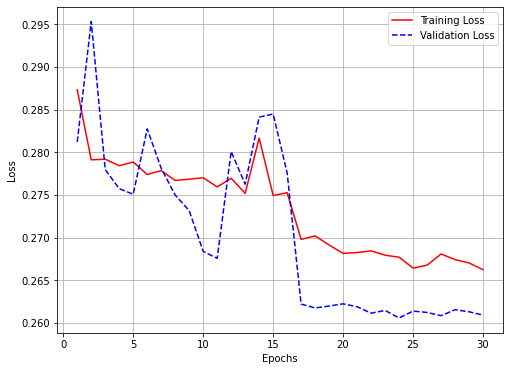

In [9]:
LT = []
LV = []

for i in range(len(Losses)):
    LT.append(Losses[i]["train"])
    LV.append(Losses[i]["valid"])

plt.figure(figsize=(8, 6))
plt.plot([i+1 for i in range(len(LT))], LT, "r", label="Training Loss")
plt.plot([i+1 for i in range(len(LV))], LV, "b--", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()